# Peg Keeper Death Spiral Simulation

Here we create a Peg Keeper object for each existing Peg Keeper, and hook it on to an existing StableSwap pool using Curvesim. Then we simulate agents acting against these Peg Keepers and pools based on some input market prices.

The specific input we are studying in this notebook is if the market price for one of the four peg keeper tokens depegs.

In [1]:
from curvesim.pool import get_sim_pool
import numpy as np
from src.modules.pegkeeperv1 import PegKeeperV1
from src.modules.aggregator import AggregateStablePrice
from src.agents import Arbitrageur
from src.utils.plotting import plot_stableswap_balances, make_gif, plot_combined_2
from src.utils.plotting import fn_frames_stableswap_bals, fn_gif_stableswap_bals
import matplotlib.pyplot as plt
from curvesim.pool import SimCurvePool

%load_ext autoreload
%autoreload 2

In [2]:
USDC_POOL = "0x4DEcE678ceceb27446b35C672dC7d61F30bAD69E"
USDT_POOL = "0x390f3595bca2df7d23783dfd126427cceb997bf4"
USDP_POOL = "0xca978a0528116dda3cba9acd3e68bc6191ca53d0"
TUSD_POOL = "0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0"

# Aggregator Params
SIGMA = 0.001

# PegKeeper Params
CALLER_SHARE = 0.2
CEILING = 25_000_000  # For USDC/USDT

In [3]:
pools = [get_sim_pool(address, balanced=False) for address in [USDC_POOL, USDT_POOL]]
# pools = {address:get_sim_pool(address, balanced=False) for address in [USDC_POOL, USDT_POOL, USDP_POOL, TUSD_POOL]}
arbitrageur = Arbitrageur(0, True)
agg = AggregateStablePrice(pools, SIGMA)
pks = [PegKeeperV1(pool, agg, CALLER_SHARE, CEILING) for pool in pools]

Goal: Implement a function that determines the profit from moving pool price to some target price, then use scipy's optimize to find the most profitable trade. This should account for external market slippage.

Would be cool to then incorporate this into `curvesim` as a `LiquidityLimitedArbitrage`! However, this would likely result in a surprising amount of work, so let's keep things simple for now.

## Showing that profit maximization is working

0.9979002099790021


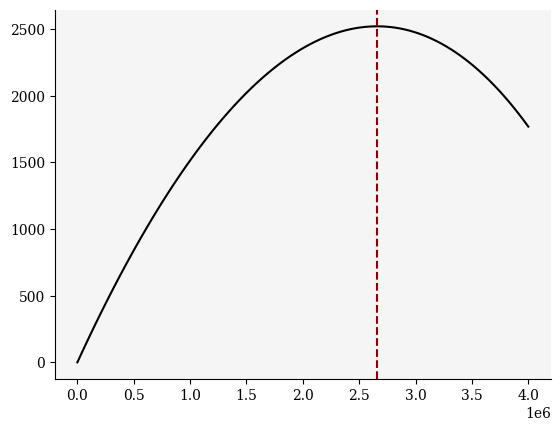

In [5]:
# USDC -> crvusd/USDC -> crvusd -> crvusd/USDT -> USDT # This `search` function does this trade
# Completed: USDT -> USDC ### Externally! # TODO The `search` function doesn't *YET* do this trade

I = 1
PRECISION = 1e18

p_usdc = 0.998  # Market price of USDC/USD
p_usdt = 1.0001  # Market price of USDT/USD
p = p_usdc / p_usdt  # <- market price of USDC/USDT externally
prices = [p_usdc, p_usdt]  # arbitrary USDC/USDT, USDT/USDC prices
print(p)
amts = np.linspace(0, 4_000_000, 100)
profits = [Arbitrageur.profit(amt_in, pools[0], pools[1], p) for amt_in in amts]
trade = Arbitrageur.search(pools, prices)

plt.plot(amts, profits, color="black")
plt.axvline(trade.size / PRECISION, color="darkred", linestyle="--")

In [6]:
profit = arbitrageur.arbitrage(pools, prices)

Arbitrage trade with profit 2520.


In [7]:
pools_cp = [get_sim_pool(address, balanced=False) for address in [USDC_POOL, USDT_POOL]]
print(
    "Original price from Curve pools:",
    pools_cp[0].price(0, 1) / pools_cp[1].price(0, 1),
)
print("Market price:", p)
print("Final price from Curve pools:", pools[0].price(0, 1) / pools[1].price(0, 1))

Original price from Curve pools: 0.9999444481231948
Market price: 0.9979002099790021
Final price from Curve pools: 0.9980999480855948


Notice that the arbitrage process correctly brings the price from the crvUSD pools closer to the prevailing market price for those tokens! This indicates that the logic for our arbitrage is correct. Of course, due to fees and price impact on Curve pools, the prices aren't perfectly equilibrated.

# Testing an Arbitrage Simulation with Peg Keeper

In [8]:
from datetime import datetime
from src.sim.prices import get_prices_df
from curvesim.network.coingecko import coin_ids_from_addresses_sync
from src.utils import get_crvusd_index

In [9]:
USDC = "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48"
USDT = "0xdac17f958d2ee523a2206206994597c13d831ec7"

coins = [USDC, USDT]
coins = coin_ids_from_addresses_sync(coins, "mainnet")

start = datetime(2023, 3, 5).timestamp()
end = datetime(2023, 3, 15).timestamp()

df = get_prices_df(coins, start, end)

[DEBUG][15:38:27][urllib3.connectionpool]-19908: Starting new HTTPS connection (1): api.coingecko.com:443
[DEBUG][15:38:27][urllib3.connectionpool]-19908: https://api.coingecko.com:443 "GET /api/v3/coins/usd-coin/market_chart/range?vs_currency=usd&from=1677992400.0&to=1678852800.0 HTTP/1.1" 200 None
[DEBUG][15:38:27][urllib3.connectionpool]-19908: Starting new HTTPS connection (1): api.coingecko.com:443
[DEBUG][15:38:28][urllib3.connectionpool]-19908: https://api.coingecko.com:443 "GET /api/v3/coins/tether/market_chart/range?vs_currency=usd&from=1677992400.0&to=1678852800.0 HTTP/1.1" 200 None


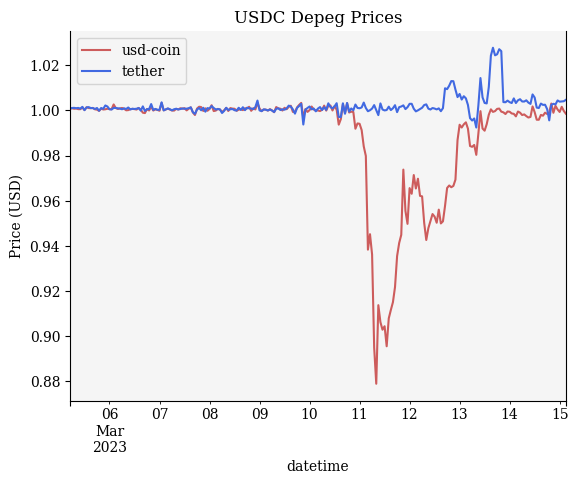

In [18]:
df["usd-coin"].plot(label="usd-coin", color="indianred")
df["tether"].plot(label="tether", color="royalblue")
plt.legend()
plt.title("USDC Depeg Prices")
plt.ylabel("Price (USD)")
plt.savefig("../figs/manual/depeg_prices.png")

In [11]:
def price_str(pool, crvusd_is_quote=True):
    idx = get_crvusd_index(pool)
    if not crvusd_is_quote:
        idx = idx ^ 1
    coins = pool.metadata["coins"]["names"]
    return f"{coins[idx^1]}_{coins[idx]}"


def pool_str(pool):
    name = pool.metadata["name"]
    name = name.replace("Curve.fi Factory Plain Pool: ", "")
    name = name.replace("/", "_")
    return name + "_pool"


def price(pool, crvusd_is_quote=True):
    idx = get_crvusd_index(pool)
    if not crvusd_is_quote:
        idx = idx ^ 1
    return pool.price(idx ^ 1, idx)


def bal_str(pool, i):
    _pool_str = pool_str(pool)
    coin = pool.metadata["coins"]["names"][i]
    return _pool_str + "_" + coin + "_bal"


def lp_supply_str(pool: SimCurvePool):
    return pool_str(pool) + "_lp_supply"

In [12]:
"""
Some Metrics
------------
Balances <- Done
Price <- Done
LP Token Supply <- Done
Virtual Price
Arbitrage PnL <- Done
Update PnL <- Done
Update minted
Update burned
Net unbacked crvusd
Net PK Profits
Aggregator price <- Done
"""

for i, row in df.iterrows():
    # arbitrageurs will arbitrage the pools
    prices = np.array(row[coins])
    arbitrage_pnl, arbitrage_count = arbitrageur.arbitrage(pools, prices)

    # Constraint 1: All arbs must only include 2 Curve pools/llamas: USDC -> crvusd -> USDT -> USDC
    #                                                                   crvusd/USDC -> crvusd/USDT
    # Constraint 2: Only include the 4 Stableswap pools for now (no LLAMMAs)

    # arbitraguers call the PK.update() function
    update_pnl, update_count = arbitrageur.update(pks, row["timestamp"])

    # Track metrics
    df.loc[i, "update_pnl"] = update_pnl
    df.loc[i, "update_count"] = update_count
    df.loc[i, "arbitrage_pnl"] = arbitrage_pnl
    df.loc[i, "arbitrage_count"] = arbitrage_count
    df.loc[i, "p_agg"] = agg.price()

    for pool in pools:
        df.loc[i, price_str(pool)] = price(pool)
        df.loc[i, lp_supply_str(pool)] = pool.tokens / 1e18
        for coin_idx, bal in enumerate(pool.balances):
            df.loc[i, bal_str(pool, coin_idx)] = bal / 1e18

Arbitrage trade with profit 2131.
Arbitrage trade with profit 3.
Arbitrage trade with profit 13.
Arbitrage trade with profit 26.
Arbitrage trade with profit 2.
Arbitrage trade with profit 7.
Arbitrage trade with profit 5.
Arbitrage trade with profit 119.
Arbitrage trade with profit 54.
Arbitrage trade with profit 1152.
Arbitrage trade with profit 67.
Arbitrage trade with profit 813.
Arbitrage trade with profit 4.
Arbitrage trade with profit 1421.
Arbitrage trade with profit 936.
Arbitrage trade with profit 44.
Arbitrage trade with profit 159.
Arbitrage trade with profit 76.
Arbitrage trade with profit 150.
Arbitrage trade with profit 245.
Arbitrage trade with profit 580.
Arbitrage trade with profit 7.
Arbitrage trade with profit 0.
Arbitrage trade with profit 122.
Arbitrage trade with profit 5916.
Arbitrage trade with profit 1347.
Arbitrage trade with profit 816.
Arbitrage trade with profit 97.
Arbitrage trade with profit 216.
Arbitrage trade with profit 194.
Arbitrage trade with profi

In [13]:
# FIXME speed this plotting up. Takes really long ~1.5mins

balance_cols = [bal_str(p, i) for p in pools for i in range(len(p.balances))]
ylim = df[balance_cols].max().max()

frame = 0
for i, row in df.iterrows():
    fn = fn_frames_stableswap_bals.format(frame)
    bals = np.array(row[balance_cols])
    _ = plot_stableswap_balances(pools, bals, fn=fn, ylim=ylim)
    frame += 1

make_gif(fn_frames_stableswap_bals, fn_gif_stableswap_bals, len(df), fps=10)

[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'IHDR' 16 13
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'tEXt' 41 57
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'pHYs' 110 9
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'IDAT' 131 65536
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'IHDR' 16 13
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'tEXt' 41 57
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'pHYs' 110 9
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'IDAT' 131 65536
[DEBUG][20:28:27][PIL.Image]-14873: Error closing: Operation on closed image
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'IHDR' 16 13
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'tEXt' 41 57
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'pHYs' 110 9
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'IDAT' 131 65536
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b'IHDR' 16 13
[DEBUG][20:28:27][PIL.PngImagePlugin]-14873: STREAM b

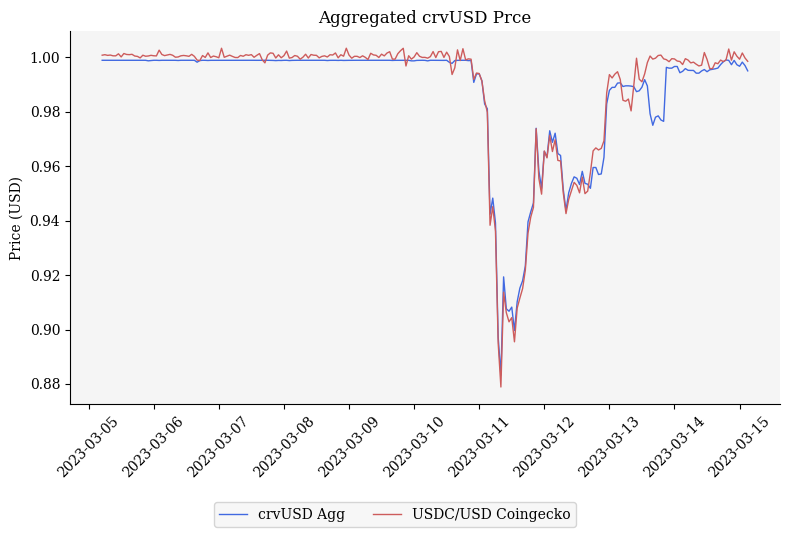

In [20]:
def plot_p_agg(df, comp=None, fn=None):
    f, ax = plt.subplots(figsize=(8, 5))

    ax.plot(df.index, df.p_agg, color="royalblue", lw=1, label="crvusd Agg")
    if comp:
        ax.plot(df.index, df[comp], color="indianred", label="USDC/USD Coingecko", lw=1)

    ax.set_title("Aggregated crvusd Price")
    ax.set_ylabel("Price (USD)")
    ax.tick_params(axis="x", rotation=45)

    f.tight_layout()
    f.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=2)

    if fn:
        plt.savefig(fn, bbox_inches="tight", dpi=300)
        plt.close()  # don't show

    return f


plot_p_agg(df, comp="usd-coin", fn="../figs/test_agg_price.png")

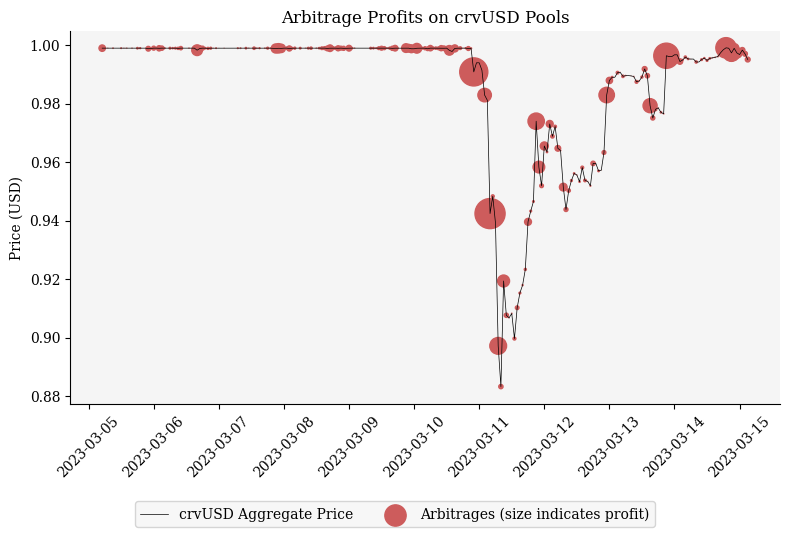

In [22]:
def plot_arb_actions(df, fn=None):
    """
    For plotting actions against StableSwap
    pools including PK update() and pool
    arbs.
    """
    f, ax = plt.subplots(figsize=(8, 5))

    ax.plot(df.index, df["p_agg"], c="black", lw=0.5, label="crvusd Aggregate Price")
    ax.scatter(
        df.index,
        df["p_agg"],
        c="indianred",
        s=df["arbitrage_pnl"] / 1e2,
        label="Arbitrages (size indicates profit)",
    )
    # ax.scatter(df.index, df['p_agg'], c='royalblue', s=df['update_pnl'], label='Updates')
    ax.tick_params(axis="x", rotation=45)
    ax.set_title("Arbitrage Profits on crvusd Pools")
    ax.set_ylabel("Price (USD)")

    f.tight_layout()
    f.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=2)

    if fn:
        plt.savefig(fn, bbox_inches="tight", dpi=300)
        plt.close()  # don't show

    return f


plot_arb_actions(df, fn="../figs/test_arbitrage_profits.png")

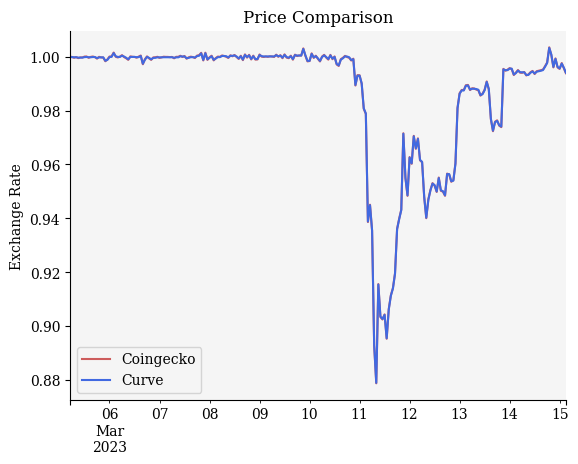

In [16]:
(df["usd-coin"] / df["tether"]).plot(label="Coingecko", color="indianred")
(df["USDC_crvusd"] / df["USDT_crvusd"]).plot(label="Curve", color="royalblue")
plt.title("Price Comparison")
plt.ylabel("Exchange Rate")
plt.xlabel("")
plt.legend()
plt.show()

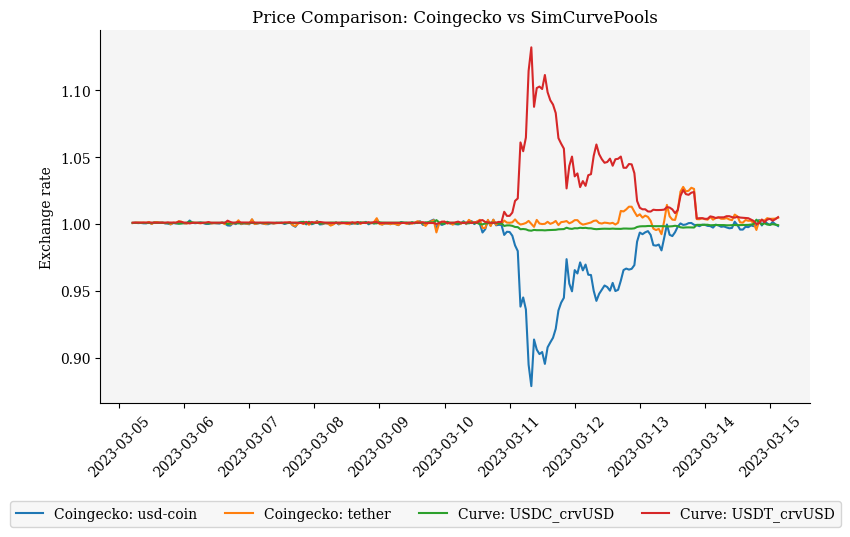

In [24]:
def plot_prices(df, coins, pools, fn=None):
    """
    Assume each Coingecko coin has 1 corresponding crvusd pool.
    """

    f, ax = plt.subplots(figsize=(8, 5))

    for coin in coins:
        ax.plot(df.index, df[coin], label="Coingecko: " + coin)
    for pool in pools:
        _price_str = price_str(pool)
        ax.plot(df.index, df[_price_str], label="Curve: " + _price_str)

    ax.set_ylabel("Exchange rate")
    ax.set_xlabel("")
    ax.set_title("Price Comparison: Coingecko vs SimCurvePools")
    ax.tick_params(axis="x", rotation=45)
    f.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=4)
    f.tight_layout()

    if fn:
        plt.savefig(fn, bbox_inches="tight", dpi=300)
        plt.close()  # don't show

    return f


plot_prices(df, coins, pools, fn="../figs/test_prices.png")

In [19]:
plot_combined_2(fps=10)

[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'IHDR' 16 13
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'tEXt' 41 57
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'pHYs' 110 9
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'IDAT' 131 65536
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'IHDR' 16 13
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'tEXt' 41 57
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'pHYs' 110 9
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'IDAT' 131 65536
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'IHDR' 16 13
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'tEXt' 41 57
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'pHYs' 110 9
[DEBUG][23:10:45][PIL.PngImagePlugin]-19908: STREAM b'IDAT' 131 65536
[DEBUG][23:10:56][PIL.Image]-19908: Importing BlpImagePlugin
[DEBUG][23:10:56][PIL.Image]-19908: Importing BmpImagePlugin
[DEBUG][23:10:56][PIL.Image]-19908: Importing BufrStubImagePlugin
[DEBUG][

# Prelim Takeaways

## crvUSD Peg

As USDC depegs, arbitrageurs try selling USDC to the USDC/crvUSD pool, and exchanging it for USDT in the USDT/crvUSD pool. We assume arbitrageurs don't hold crvUSD. Unfortunately, the PKs are unable to maintain crvUSD's peg for two reasons:

1. The PK can't burn crvUSD from the USDT/crvUSD pool, because it never provided any in the first place. That is: the PK can't burn other people's crvUSD.
2. The PK can't mint crvUSD into the USDC/crvUSD pool, because p_agg is below 1 (due to USDT/crvUSD pool). 

The main problem is that demand for the non-depegging token (USDT) skyrockets as USDC depegs, leading to crvUSD being largely underpriced in the USDT/crvUSD pool, and only moderately overpriced in the USDC/crvUSD pool.

Main takeaway: the dependency on stablecoins (e.g. USDC) exists despite the PK.

## Arbitrageur Profits

We show that arbitrageurs maintain a tight spread between external USDC/USDT price and internal USDC/USDT price on crvUSD pools. For this, they are rewarded with relatively small profits: a total of ~$350K. We currently tally profits in the `token_out`, but this is wrong and should ultimately be converted to USD profits at prevailing market prices.

## To Do

- Why are arbitrage profits so low? 350k for this weekend seems absurdly little.
- Create metrics class like in curvesim/
- Incorporate LPs adding/pulling liquidity?